---

  # Deep Learning and VGG16 Transfer Learning based Flower Recognition
This is the code for the project entitled "**Deep Learning and VGG16 Transfer Learning based Flower Recognition**" submitted as the course project of **ECE 9039@UWO**<br>  
Author: Zhijun Li (zli2945@uwo.ca) and Liang Zhang (lzha46@uwo.ca)<br>
Date: 01 March, 2023<br>
  

**Notebook 1: Hand-designed CNN model with Random Search HPO**  
Purpose:  
&nbsp; 1): Generate training and test images<br>
&nbsp; 2): Complete data exploratory analysis<br>
&nbsp; 3): Construct hand-designed CNN model<br>
&nbsp; 4): Tune the hyperparameters of CNN models by using random search technique

---

## Import libraries

In [38]:
# ignore the warnings for smooth progress
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#import tensorflow as tf
#import random as rn
 
# data preparation
import cv2           
import os  

# data preprocess
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

# model selection and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
confusion_matrix, ConfusionMatrixDisplay, classification_report

# cnn model libraraies
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D  
    
# HPO related
from hyperopt import hp, fmin, rand, STATUS_OK
from hyperopt.early_stop import no_progress_loss

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
np.random.seed(42)

In [ ]:
# use magic function 'inline' to regulate the position of plots next to the code
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

## Data exploratory analysis (Execute once for a dataset)

In [ ]:
def load_img_shapes(path_to_img):
    return cv2.imread(path_to_img).shape

In [ ]:
# Only for DEA, no need to maintain for 
train_shapes = []
folder_name = 'Proj_Datasets'
flower_name_list = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

for flower_name in flower_name_list:
    valid_DataCnt = 0
    full_path = os.path.join(folder_name, flower_name)

    # os.listdir: get all files under DIR
    for pic in os.listdir(full_path):
        img_path = os.path.join(full_path,pic)
        train_shapes.append(load_img_shapes(img_path))
    

df_train = pd.DataFrame({'Shapes': train_shapes})
train_counts = df_train['Shapes'].value_counts()
print("Data Image Shapes:")
for i in range(len(train_counts)):
    print("Shape %s counts: %d" % (train_counts.index[i], train_counts.values[i]))
print("*"*50)

In [ ]:
# plot distribution of train/test image shapes
train_counts2 = train_counts.drop(train_counts[train_counts.values < 50].index)
plt.figure(figsize=(20, 30))
sns.barplot(x=train_counts2.index, y=train_counts2.values)
plt.title("[Flower Recognition] Exploratory Analysis: Image Size (counts >= 50)")
plt.show()

## Data preparation

In [4]:
def dataset_prep(flower_name_list): 
    #IMG_SIZE=224 #150
    folder_name = 'Proj_Datasets'
    
    for flower_name in flower_name_list:
        valid_DataCnt = 0
        full_path = os.path.join(folder_name, flower_name)

        # os.listdir: get all files under DIR
        for pic in os.listdir(full_path):
            pic_path = os.path.join(full_path,pic) #full_path + '/' + pic
            # read img from path with default setting 'IMREAD_COLOR'
            this_pic = cv2.imread(pic_path, cv2.IMREAD_COLOR)
            this_pic = cv2.resize(this_pic, (IMG_SIZE, IMG_SIZE))
            X_data.append(np.array(this_pic))
            y_data.append(str(flower_name))
            if(valid_DataCnt < 200):
                X_validation.append(np.array(this_pic))
                y_validation.append(str(flower_name))
            valid_DataCnt += 1
        print("Finish processing {0}\nX_data's size: {1:5d}\tX_validation's size: {2}\
        y_data's size: {3:5d}\ty_validation's size: {4}\n".format(flower_name,len(X_data),len(X_validation),len(y_data),len(y_validation)))

In [5]:
# Xy_data: original dataset
# Xy_train: training set
# Xy_test: testing set
# Xy_validation: validation set

X_data = []
X_train = []
X_test = []
X_validation = []

y_data = []
y_train = []
y_test = []
y_validation = []

IMG_SIZE=150 #225
    
flower_name_list = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
dataset_prep(flower_name_list)

Finish processing daisy
X_data's size:   764	X_validation's size: 200        y_data's size:   764	y_validation's size: 200

Finish processing dandelion
X_data's size:  1816	X_validation's size: 400        y_data's size:  1816	y_validation's size: 400

Finish processing rose
X_data's size:  2600	X_validation's size: 600        y_data's size:  2600	y_validation's size: 600

Finish processing sunflower
X_data's size:  3333	X_validation's size: 800        y_data's size:  3333	y_validation's size: 800

Finish processing tulip
X_data's size:  4317	X_validation's size: 1000        y_data's size:  4317	y_validation's size: 1000



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=42) 

## Data preprocessing

In [7]:
def XY_prep(X, y): 
    # label encoding
    le=LabelEncoder()
    y_labeled=le.fit_transform(y)
    # transform Y to binary one-hot encoding
    y_coded=to_categorical(y_labeled,5)

    X=np.array(X)
    # Convergence, scaling the pixel values between [0, 1], avoids neuron fall into 'death zone'
    X_coded=X/255
    return X_coded, y_coded, y_labeled, le


In [41]:
if 0:
    print('train:')
    print(np.shape(X_train))
    print(np.shape(y_train))
    print('test:')
    print(np.shape(X_test))
    print(np.shape(y_test))
    print('train_validation:')
    print(np.shape(X_validation))
    print(np.shape(y_validation))

In [9]:
X_train_coded, y_train_coded, y_train_labeled, le_train = XY_prep(X_train, y_train)
X_test_coded, y_test_coded, y_test_labeled, le_test = XY_prep(X_test, y_test)
X_validation_coded, y_validation_coded, y_validation_labeled, le_validation = XY_prep(X_validation, y_validation)

In [42]:
if 0:
    print('train_coded:')
    print(np.shape(X_train_coded))
    print(np.shape(y_train_coded))
    print('test_coded:')
    print(np.shape(X_test_coded))
    print(np.shape(y_test_coded))
    print('train_validation_coded:')
    print(np.shape(X_validation_coded))
    print(np.shape(y_validation_coded))

## Model construction

In [12]:
def Random_Search_CNN_Also_Train(epochs=50,
                               num_filter_1 = 32, num_filter_2 = 32, num_filter_3 = 32, num_filter_4 = 32,
                               learning_rate = 0.001, 
                                neurons_dense = 512, 
                               verbose=1):
    
    # layers=4, which was the HPO result from Notebook 0
    model = Sequential()
    model.add(Conv2D(filters = num_filter_1, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Conv2D(filters = num_filter_2, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


    model.add(Conv2D(filters = num_filter_3, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(filters = num_filter_4, kernel_size = (3,3), padding = 'Same', activation ='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # convert multidimension into one dimension
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(neurons_dense))
    model.add(Activation('relu'))
    # below 5 is the number of flowers' classes
    model.add(Dense(5, activation = "softmax"))
    
    # 2. data augmentation
    batch_size=128
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    datagen.fit(X_train_coded)
    
    # 3. compile the model specifying an optimizer, a metrics and a loss function
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    # 4. fit this model
    hist= model.fit_generator(datagen.flow(X_train_coded,y_train_coded, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_validation_coded,y_validation_coded), #TODO: X_validation_coded
                              verbose = verbose, 
                              steps_per_epoch=X_train_coded.shape[0] // batch_size)
    
    return hist, model

## HPO and model training

In [15]:
def objective(params):
    
    params = {
        'num_filter_1': int(params['num_filter_1']),
        'num_filter_2': int(params['num_filter_2']),
        'num_filter_3': int(params['num_filter_3']),
        'num_filter_4': int(params['num_filter_4']),
        'epochs': int(params['epochs']),
        #'learning_rate': abs(float(params['learning_rate'])),
        'neurons_dense': int(params['neurons_dense']),
        
    }
    num_filter_1=params['num_filter_1']
    num_filter_2=params['num_filter_2']
    num_filter_3=params['num_filter_3']
    num_filter_4=params['num_filter_4']
    epochs=params['epochs']
    #learning_rate=params['learning_rate']
    neurons_dense=params['neurons_dense']
    
    this_hist, this_model = Random_Search_CNN_Also_Train(epochs=epochs,
                                num_filter_1 = num_filter_1, num_filter_2 = num_filter_2, 
                                num_filter_3 = num_filter_3, num_filter_4 = num_filter_4,
                                #learning_rate = learning_rate, 
                                neurons_dense = neurons_dense, 
                                verbose=0)
    
    # predit
    y_pred=this_model.predict(X_test_coded)
    # get the predict result as label 0-5 from the highest marks
    y_pred_labeled=np.argmax(y_pred,axis=1)
    # convert the y_test from flower type str to label 0-5
    le=LabelEncoder()
    y_test_labeled=le.fit_transform(y_test)
    
    '''
    print("y_test_labeled:")
    display(y_test_labeled)
    print("y_pred_labeled:")
    display(y_pred_labeled)
    '''
    
    acc = accuracy_score(y_test_labeled, y_pred_labeled)
    print('accuracy_score:%s'%acc)
    return {'loss': -acc, 'status': STATUS_OK }

In [16]:
space = {
    'num_filter_1': hp.choice('num_filter_1', [32, 64, 96]),
    'num_filter_2': hp.choice('num_filter_2',  [32, 64, 96]),
    'num_filter_3': hp.choice('num_filter_3',  [32, 64, 96]),
    'num_filter_4': hp.choice('num_filter_4',  [32, 64, 96]),
    'epochs': hp.quniform('epochs', 40, 60, 10),
    'neurons_dense': hp.choice('neurons_dense', [256, 512, 1024]),
    #'learning_rate': hp.quniform('lr', 0.001, 0.003, 0.001), 
}

early_stop_fn = no_progress_loss(10)

t1=time.time()
best = fmin(fn=objective,
            space=space,
            algo=rand.suggest,
            max_evals=10,
            early_stop_fn=early_stop_fn)

print("Hyperopt estimated optimum {}".format(best))
t2=time.time()
print("Time: "+str(t2-t1))

  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

2023-03-27 13:11:32.522179: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


34/34 [==============================] - 4s 103ms/step                         

accuracy_score:0.7592592592592593                                               
34/34 [==============================] - 2s 52ms/step                          

accuracy_score:0.7814814814814814                                               
34/34 [==============================] - 5s 139ms/step                         

accuracy_score:0.7731481481481481                                               
34/34 [==============================] - 5s 137ms/step                         

accuracy_score:0.7842592592592592                                               
34/34 [==============================] - 6s 181ms/step                         

accuracy_score:0.7805555555555556                                               
24/34 [====================>.........] - ETA: 0s                               


34/34 [==============================] - 3s 79ms/step                          

accuracy_score:0.7944444444444444                                               
34/34 [==============================] - 3s 100ms/step                         

accuracy_score:0.7925925925925926                                               
34/34 [==============================] - 5s 131ms/step                         

accuracy_score:0.7824074074074074                                               
34/34 [==============================] - 5s 149ms/step                         

accuracy_score:0.8018518518518518                                               
34/34 [==============================] - 8s 219ms/step                         

accuracy_score:0.8037037037037037                                               
100%|████| 10/10 [8:13:46<00:00, 2962.60s/trial, best loss: -0.8037037037037037]
Hyperopt estimated optimum {'epochs': 50.0, 'neurons_dense': 0, 'num_filter_1': 2, 'num_filter_2': 2, 'num_fi

In [17]:
# get kernel and test this model config below
this_hist, this_model = Random_Search_CNN_Also_Train(epochs=50,
                                num_filter_1 = 96, num_filter_2 = 96, num_filter_3 = 64, num_filter_4 = 64,
                               learning_rate = 0.001, 
                                neurons_dense = 256, 
                               verbose=1)

Epoch 1/50
25/25 [==============================] - 99s 4s/step - loss: 1.4660 - accuracy: 0.3233 - val_loss: 1.2499 - val_accuracy: 0.4840
Epoch 2/50
25/25 [==============================] - 96s 4s/step - loss: 1.1997 - accuracy: 0.4995 - val_loss: 1.1264 - val_accuracy: 0.5330
Epoch 3/50
25/25 [==============================] - 95s 4s/step - loss: 1.1025 - accuracy: 0.5645 - val_loss: 0.9937 - val_accuracy: 0.6150
Epoch 4/50
25/25 [==============================] - 97s 4s/step - loss: 1.0030 - accuracy: 0.6069 - val_loss: 0.9422 - val_accuracy: 0.6360
Epoch 5/50
25/25 [==============================] - 95s 4s/step - loss: 0.9909 - accuracy: 0.6111 - val_loss: 1.0211 - val_accuracy: 0.6120
Epoch 6/50
25/25 [==============================] - 95s 4s/step - loss: 0.9595 - accuracy: 0.6137 - val_loss: 0.8908 - val_accuracy: 0.6520
Epoch 7/50
25/25 [==============================] - 97s 4s/step - loss: 0.9241 - accuracy: 0.6304 - val_loss: 0.8564 - val_accuracy: 0.6840
Epoch 8/50
25/25 [==

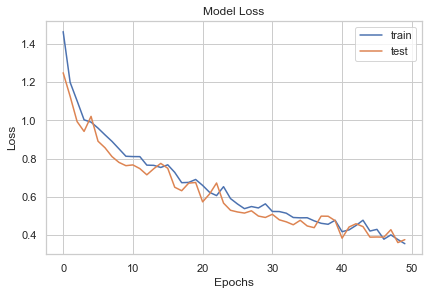

In [18]:
plt.plot(this_hist.history['loss'])
plt.plot(this_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

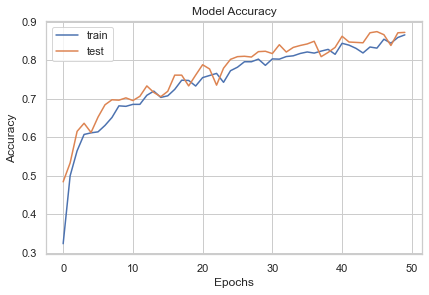

In [19]:
plt.plot(this_hist.history['accuracy'])
plt.plot(this_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Model prediction

In [31]:
y_pred_test=this_model.predict(X_test_coded)
# get the predict result as label 0-5 from the highest marks
y_pred_test_labeled=np.argmax(y_pred_test,axis=1)
# convert the y_test from flower type str to label 0-5
le=LabelEncoder()
y_test_labeled=le.fit_transform(y_test)

34/34 [==============================] - 8s 215ms/step


In [26]:
# getting predictions on val set.
y_pred_train=this_model.predict(X_train_coded)
# get the predict result as label 0-5 from the highest marks
y_pred_train_labeled=np.argmax(y_pred_train,axis=1)

102/102 [==============================] - 23s 220ms/step


## Result evaluation

In [21]:
acc = accuracy_score(y_test_labeled, y_pred_labeled)
print(acc)
prec = precision_score(y_test_labeled, y_test_labeled, average='weighted')
print(prec)
recall = recall_score(y_test_labeled, y_pred_labeled, average='weighted')
print(recall)
f1 = f1_score(y_test_labeled, y_pred_labeled, average='weighted')
print(f1)

#confusion_matrix = confusion_matrix
print('accuracy: %s'%acc)
print('precision: %s'%prec)
print('recall: %s'%recall)
print('f1: %s'%f1)

0.8027777777777778
1.0
0.8027777777777778
0.803266759215475
accuracy: 0.8027777777777778
precision: 1.0
recall: 0.8027777777777778
f1: 0.803266759215475


In [22]:
# now storing some properly as well as misclassified indexes
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test_coded)):
    if(y_test_labeled[i]==y_pred_labeled[i]):
        if(len(prop_class)<8):
            prop_class.append(i)
    else:
        if(len(mis_class)<8):
            mis_class.append(i)

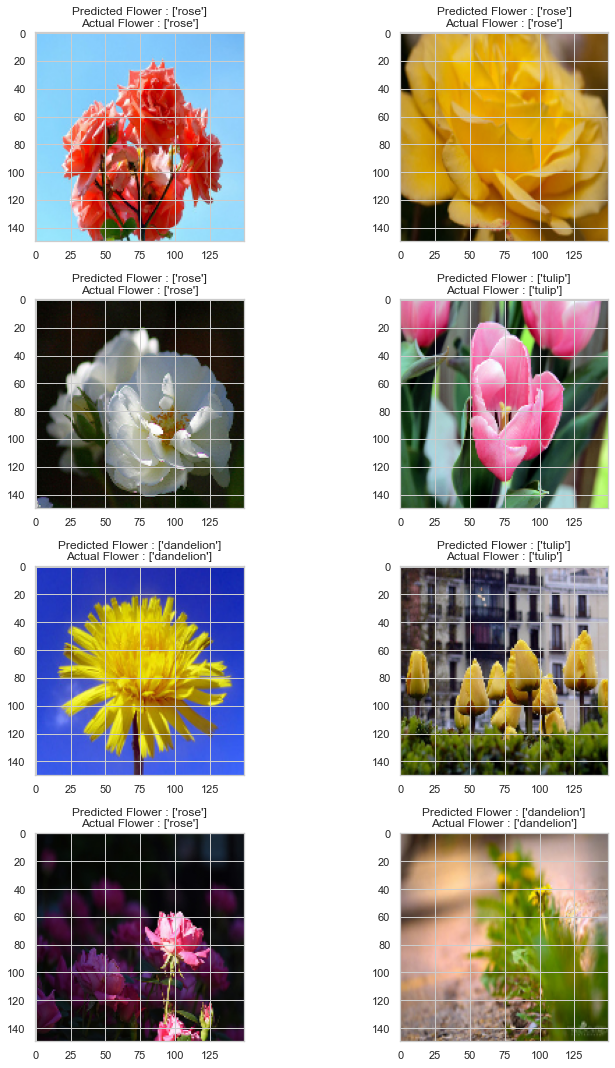

In [23]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test_coded[prop_class[count]][:,:,[2,1,0]])
        ax[i,j].set_title("Predicted Flower : "+str(le_test.inverse_transform([y_pred_labeled[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le_test.inverse_transform([y_test_labeled[prop_class[count]]])))
        plt.tight_layout()
        count+=1

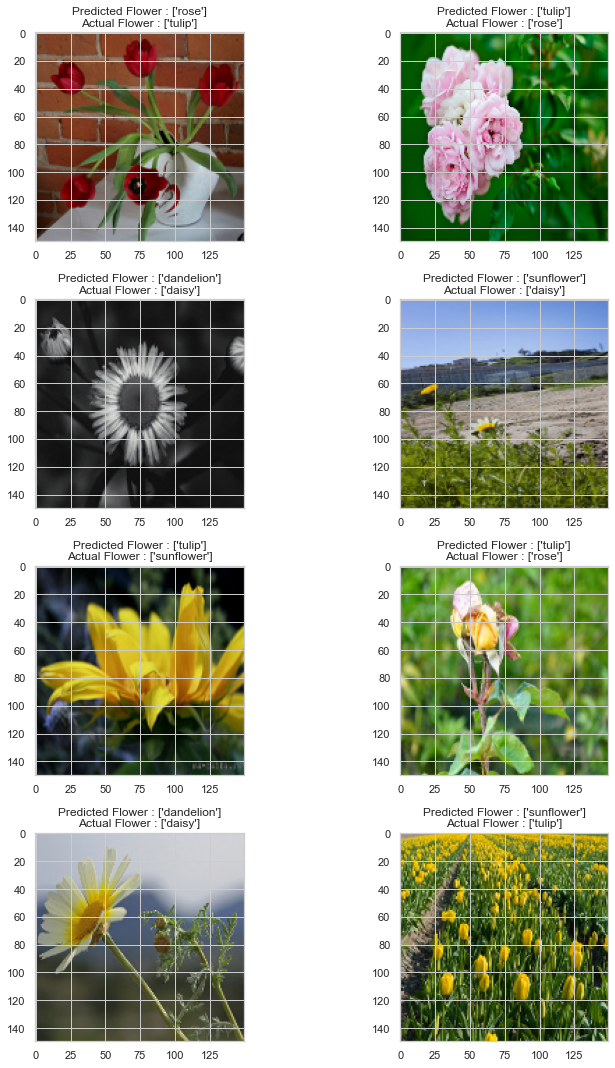

In [24]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(X_test_coded[mis_class[count]][:,:,[2,1,0]])
        ax[i,j].set_title("Predicted Flower : "+str(le_test.inverse_transform([y_pred_labeled[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le_test.inverse_transform([y_test_labeled[mis_class[count]]])))
        plt.tight_layout()
        count+=1

Text(0.5, 1.0, '[Flower Recognition] Confusion Matrix of Training Datasets Prediction, by using HPO-Rand')

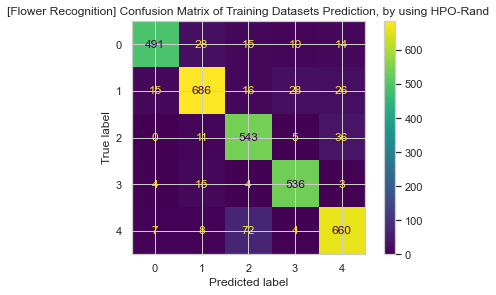

In [27]:
cm_train= confusion_matrix(y_train_labeled,y_pred_train_labeled)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train )

disp_train.plot()
disp_train.ax_.set_title("[Flower Recognition] Confusion Matrix of Training Datasets Prediction, by using HPO-Rand")

Text(0.5, 1.0, '[Flower Recognition] Heatmap of Training Datasets Prediction, by using HPO-Rand')

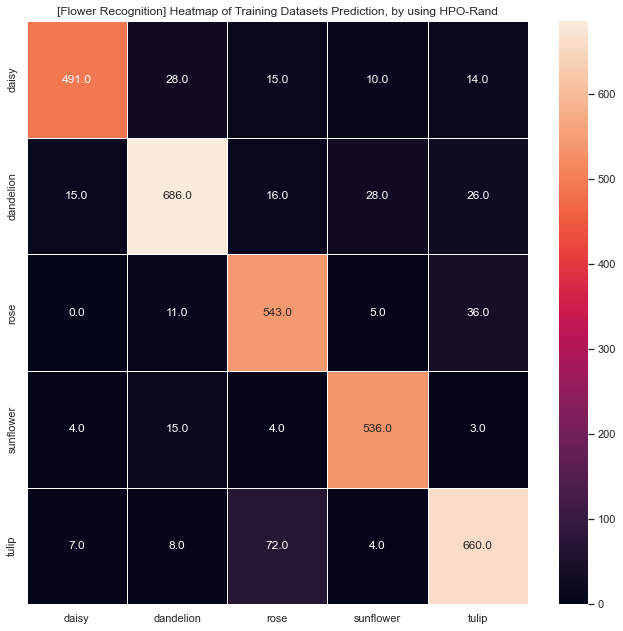

In [29]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_train, annot=True, fmt=".1f", linewidth=.5, xticklabels=flower_name_list, yticklabels=flower_name_list)
plt.title("[Flower Recognition] Heatmap of Training Datasets Prediction, by using HPO-Rand")

Text(0.5, 1.0, '[Flower Recognition] Confusion Matrix of Test Datasets Prediction, by using HPO-Rand')

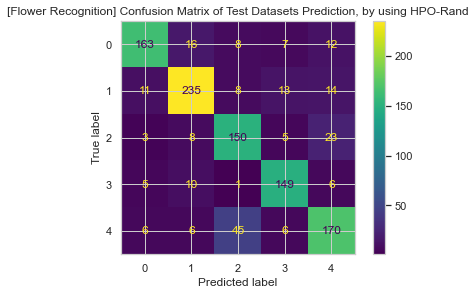

In [32]:
cm_test= confusion_matrix(y_test_labeled,y_pred_test_labeled)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test )

disp_test.plot()
disp_test.ax_.set_title("[Flower Recognition] Confusion Matrix of Test Datasets Prediction, by using HPO-Rand")

Text(0.5, 1.0, '[Flower Recognition] Heatmap of Test Datasets Prediction, by using HPO-Rand')

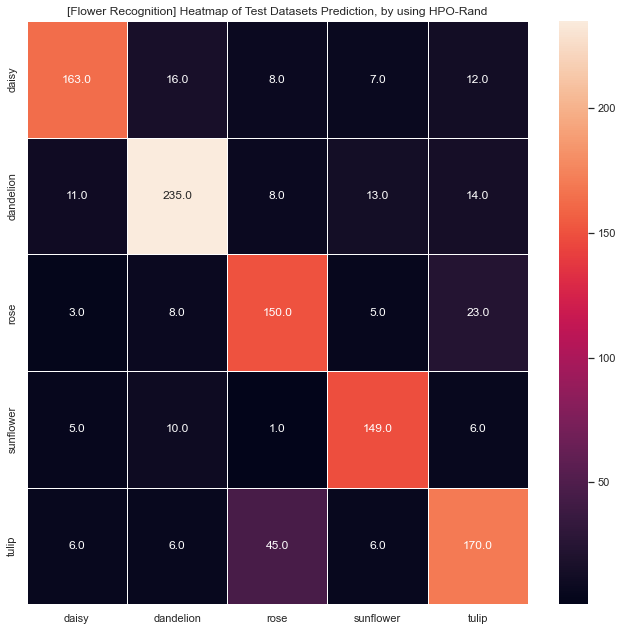

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(cm_test, annot=True, fmt=".1f", linewidth=.5, xticklabels=flower_name_list, yticklabels=flower_name_list)
plt.title("[Flower Recognition] Heatmap of Test Datasets Prediction, by using HPO-Rand")

In [34]:
print("[Flower Recognition] Classification Repot of Test Datasets Prediction, by using HPO-Rand\r\n")
print(classification_report(y_test_labeled, y_pred_test_labeled, target_names = flower_name_list))

[Flower Recognition] Classification Repot of Test Datasets Prediction, by using HPO-Rand

              precision    recall  f1-score   support

       daisy       0.87      0.79      0.83       206
   dandelion       0.85      0.84      0.85       281
        rose       0.71      0.79      0.75       189
   sunflower       0.83      0.87      0.85       171
       tulip       0.76      0.73      0.74       233

    accuracy                           0.80      1080
   macro avg       0.80      0.80      0.80      1080
weighted avg       0.81      0.80      0.80      1080

